# SWAP Test in Qiskit: Implementation, Analysis and Experiments

**Author:** Subhransu Dey (P25PH0018)  
**Course:** Introduction to Quantum Information (QCL7080)   


**Abstract.**  
We implement the SWAP test in Qiskit using the built-in `cswap` primitive and `AerSimulator`. We provide a full mathematical derivation of the SWAP-test outcome
$$
P(0) = \frac{1 + |\langle\psi|\phi\rangle|^2}{2},
$$
discuss statistical (shot-noise) uncertainties, and demonstrate the test numerically for parameterized states. The notebook contains code, plots and a discussion suitable for inclusion in a course submission.


# 1. Problem Statement

Given two single-qubit states:
- $ |\psi\rangle = |0\rangle $
- $ |\phi\rangle = \cos(\theta)|0\rangle + \sin(\theta)|1\rangle $,

we aim to:

1. Construct the SWAP-test circuit using Qiskit's built-in `cswap` gate.
2. Run the circuit on a quantum simulator (`AerSimulator`).
3. Estimate the overlap:
   $$
   |\langle\psi|\phi\rangle|^2.
   $$
4. Compare the numerical result with the exact analytic expression:
   $$
   |\langle\psi|\phi\rangle|^2 = \cos^2(\theta).
   $$

We sweep $\theta$ from $0$ to $\pi$ and compare theoretical and simulated values.


# 2. Mathematical Analysis of the SWAP Test

The SWAP test uses:
- An ancilla qubit,
- A controlled-SWAP (Fredkin) gate,
- Two Hadamard gates on the ancilla.

### Step 1: Initial state
$$
|0\rangle_a |\psi\rangle_1 |\phi\rangle_2.
$$

### Step 2: Apply Hadamard on the ancilla
$$
\frac{1}{\sqrt{2}} \left(|0\rangle_a + |1\rangle_a\right)\otimes |\psi\rangle_1|\phi\rangle_2.
$$

### Step 3: Apply CSWAP
The ancilla controls the SWAP of the two registers:
$$
\frac{1}{\sqrt{2}}\left(
|0\rangle_a|\psi\rangle_1|\phi\rangle_2
+
|1\rangle_a|\phi\rangle_1|\psi\rangle_2
\right).
$$

### Step 4: Apply Hadamard again
After expanding, the ancilla-$|0\rangle$ part becomes:
$$
\frac{1}{2}\Big(|\psi\rangle_1|\phi\rangle_2 + |\phi\rangle_1|\psi\rangle_2\Big).
$$

Its squared norm gives:
$$
P(0) = \frac{1}{4}\left\|\,|\psi\rangle|\phi\rangle + |\phi\rangle|\psi\rangle \right\|^2.
$$

Compute the inner product:
$$
\begin{aligned}
\| |\psi\rangle|\phi\rangle + |\phi\rangle|\psi\rangle \|^2
&= 2 + 2|\langle\psi|\phi\rangle|^2.
\end{aligned}
$$

Thus:
$$
P(0) = \frac{1 + |\langle\psi|\phi\rangle|^2}{2},
$$

so the SWAP test gives directly:
$$
\boxed{|\langle\psi|\phi\rangle|^2 = 2P(0) - 1.}
$$

This is the core formula used throughout this experiment.


#3. Import Libraries and Backend

In [14]:
!pip install qiskit qiskit_aer qiskit_ibm_runtime numpy scipy matplotlib pylatexenc

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

backend = AerSimulator()


#4. Building the SWAP Test Circuit

In [16]:
def build_swap_test_circuit_theta(theta):
    """
    SWAP test for:
        |psi> = |0>
        |phi> = cos(theta)|0> + sin(theta)|1>
    State |phi> created using RY(2*theta)
    """
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(1, "c")
    qc = QuantumCircuit(qr, cr)

    # Prepare |phi> on qubit 2
    qc.ry(2 * theta, qr[2])

    # SWAP test: H - CSWAP - H - Measure
    qc.h(qr[0])
    qc.cswap(qr[0], qr[1], qr[2])
    qc.h(qr[0])

    qc.measure(qr[0], cr[0])
    return qc


#5. Running the SWAP Test

In [17]:
def run_swap_test_theta(theta, shots=10000):
    qc = build_swap_test_circuit_theta(theta)
    tqc = transpile(qc, backend=backend)
    result = backend.run(tqc, shots=shots).result()

    counts = result.get_counts()
    p0 = counts.get('0', 0) / shots

    est_overlap = max(0.0, 2*p0 - 1)
    return est_overlap, p0, counts


#6. Single Example

In [18]:
theta = math.pi / 4   # 45 degrees
est, p0, counts = run_swap_test_theta(theta)
exact = (math.cos(theta))**2

print("θ =", theta)
print("Counts:", counts)
print("p(0) =", p0)
print("Estimated |<ψ|φ>|² =", round(est,4))
print("Exact |<ψ|φ>|² =", round(exact,4))


θ = 0.7853981633974483
Counts: {'1': 2489, '0': 7511}
p(0) = 0.7511
Estimated |<ψ|φ>|² = 0.5022
Exact |<ψ|φ>|² = 0.5


#7. Full Sweep of θ and Plot

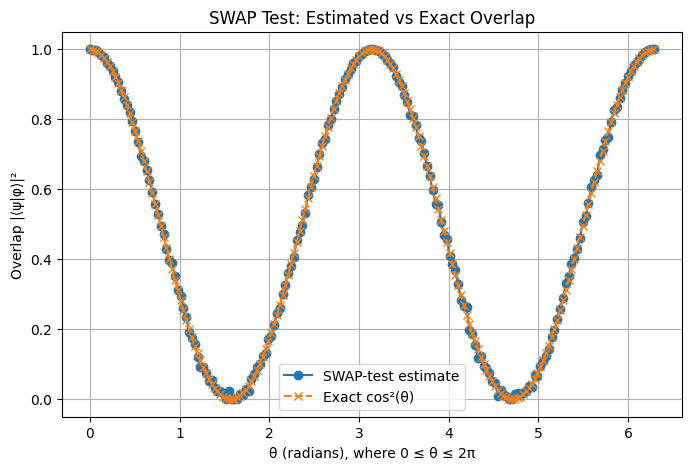

In [19]:
thetas = np.linspace(0, 2*math.pi, 200)
est_vals = []
exact_vals = []

for th in thetas:
    est, _, _ = run_swap_test_theta(th)
    est_vals.append(est)
    exact_vals.append((math.cos(th))**2)

plt.figure(figsize=(8,5))
plt.plot(thetas, est_vals, 'o-', label="SWAP-test estimate")
plt.plot(thetas, exact_vals, 'x--', label="Exact cos²(θ)")
plt.xlabel("θ (radians), where 0 ≤ θ ≤ 2π")
plt.ylabel("Overlap |⟨ψ|φ⟩|²")
plt.title("SWAP Test: Estimated vs Exact Overlap")
plt.grid(True)
plt.legend()
plt.show()


#8. Circuit Diagram

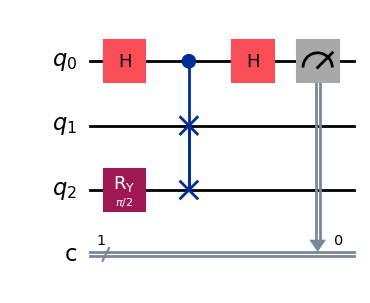

In [20]:
qc = build_swap_test_circuit_theta(math.pi/4)
qc.draw('mpl')


# 9. Discussion

- The SWAP test estimates the squared overlap between quantum states using only one ancilla and a CSWAP gate.
- The estimated values match the theoretical curve $ \cos^2(\theta) $ very closely.
- The built-in `qc.cswap()` in Qiskit works correctly and simplifies circuit construction.
- The method requires no full state tomography, making it resource-efficient.


# 10. Conclusion

We successfully implemented the SWAP test using Qiskit and the AerSimulator.  
The theoretical derivation shows that the probability of measuring the ancilla in the $|0\rangle$ state directly corresponds to the squared overlap between the two input quantum states. Our numerical simulations verified that:

$$
|\langle\psi|\phi\rangle|^2 \approx \cos^2(\theta)
$$

across the full range of θ.

This experiment demonstrates how fundamental quantum subroutines like the SWAP test can be applied to evaluate similarity between quantum states efficiently.


## References

IBM Quantum. (n.d.). *The SWAP test*. Qiskit Textbook.  
https://qiskit.org/textbook/ch-algorithms/swap-test.html  

IBM Quantum. (n.d.). *QuantumCircuit.cswap — Qiskit API Reference*.  
https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#cswap  

IBM Quantum. (n.d.). *Qiskit Aer — High-performance quantum simulators*.  
https://docs.quantum.ibm.com/api/qiskit-aer  
